In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import collections
import itertools
import time

In [152]:
def load_data(path):
    """
    load training and testing data 
    return X,Y
    """
    path = 'dataset'
    Xfiles = glob.glob(os.path.join(path,'fData*.csv'))
    yfiles = glob.glob(os.path.join(path,'fLabels*.csv'))

    X,y = [],[]

    for f in Xfiles:
        X.append(pd.read_csv(f))

    for f in yfiles:
        y.append(pd.read_csv(f).values.T[0]) 
    print('X: ',len(X),X[0].shape)
    print('y: ',len(y),y[0].shape)
    return X,y

X,y = load_data('dataset')

X:  10 (19, 2)
y:  10 (19,)


In [192]:
class GeneralizedLinearModel:
    def __init__(self,d,lam=1):
        self.d = d           # degree
        self.lam = 1         # hardcoded lambda
        self.K = None        # gram matrix
        self.a = None        # a
        self.mse = None      # mean squared err
        self.runtime = None  # runtime
        
    def basis_function(self,x):
        """
        compute the basis function 
        return basis for each point
        """
        return [x[0]**j * x[1]**(i-j) for i in range(self.d+1) for j in range(i+1)]
        
    def train(self,X,y):
        """
        train the model, and save calculated K, a to model
        """
        start = time.time()
        self.phi = np.transpose([self.basis_function(x) for i,x in X.iterrows()])
        # k = phi.T phi, 
        # here actually phi is already transposed
        self.K = np.matmul(np.transpose(self.phi),self.phi)
        # a = (K + lam I)^-1 y
        self.a = np.matmul(np.linalg.inv(self.K + self.lam * np.identity(self.K.shape[0])),y)
        self.runtime = time.time()-start
             
    def predict(self,x_test):
        """
        return a list of predictions
        """
        predictions=[]
        for idx,x in x_test.iterrows():
            predictions.append(self.point_estimate(x))
        return predictions
        
    def point_estimate(self,x):
        phix = self.basis_function(x)
        pred = np.matmul(self.a.T,np.matmul(self.phi.T,phix))
        return pred
    
    def accuracy(self,y_pred,y):
        self.mse = np.mean((y - y_pred)**2)
        return self.mse
    

In [193]:
glm = GeneralizedLinearModel(d=4)
glm.train(X[0],y[0])
predictions = glm.predict(X[1])
glm.accuracy(predictions,y[1])

76.28520249071622

In [194]:
degree = [1,2,3,4]
err = []
rt = []

def k_fold_cross_validate(k):
    """
    k fold cross validation
    returns a list of tuples (k, accuracy)
    """
    for d in degree:
        total_mse = 0.0
        total_runtime = 0.0
        for i in range(k): 
            # split train_test
            X_train = pd.DataFrame(np.vstack([train for idx,train in enumerate(X) if idx != i]))
            X_test = X[i]
            y_train = np.hstack([train for idx,train in enumerate(y) if idx != i])
            y_test = y[i]
            
            glm = GeneralizedLinearModel(d=d)
            glm.train(X_train,y_train)
            y_pred = glm.predict(X_test)
            mse = glm.accuracy(y_pred,y_test)
            total_mse += mse
            total_runtime += glm.runtime
        avg_mse = total_mse/k
        err.append(avg_mse)
        avg_runtime = round(total_runtime/k,3)
        rt.append(avg_runtime)

In [195]:
k_fold_cross_validate(10)
print('Err: ',err)
print('RT: ',rt)

Err:  [4.434032006535476, 4.545922352121751, 4.615092501105584, 4.9204523588439155]
RT:  [0.032, 0.057, 0.109, 0.111]


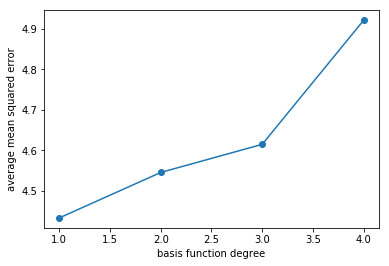

In [191]:
plt.plot(degree,err,'-o')
plt.xlabel('basis function degree')
plt.ylabel('average mean squared error')
plt.show()

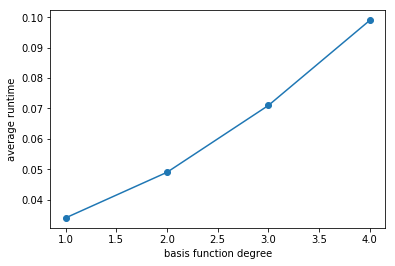

In [158]:
plt.plot(degree,rt,'-o')
plt.xlabel('basis function degree')
plt.ylabel('average runtime')
plt.show()